<img align="center" src="https://iili.io/3wI8gI.png" style="height:90px" style="width:30px"/>

<h1><center>Canceled bookings at a hotel</center></h1>

<hr style="border:3px solid pink"> </hr>



You have been assigned the task of building a model that will predict whether or not a customer of a hotel will cancel their booking. The data for this assingment is found in the csv file `hotel_clf`

<br> 
<div>
<img src="https://5.imimg.com/data5/PC/BL/MY-33192851/hotel-reservation-services-500x500.jpg" width="400"/>
</div>
<br> 
If the model predicts that a customer will cancel their booking, that customer will be sent a special deal to try to keep the customer from cancel the booking. If the prediction is correct (a True Positive), the expected gain is 1000 SEK. However, if the prediction is wrong (a False Positive), the expected loss is 500 SEK. 

Your goal is to build the most profitable model possible.


<hr style="border:3px solid pink"> </hr>

Instructions for train test split:

- Test size = 0.2
- Random state = 42

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
https://www.kaggle.com/code/niteshyadav3103/hotel-booking-prediction-99-5-acc

In [11]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Surpress future warnings
import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

pd.options.display.max_columns = 100

df = pd.read_csv('hotel_bookings.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


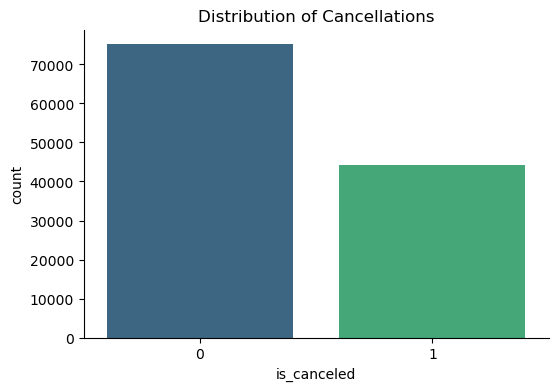

In [12]:
# Distribution of Target Variable (Class Balance)
plt.figure(figsize=(6, 4))
sns.countplot(x='is_canceled', data=df, palette='viridis')
plt.title('Distribution of Cancellations')
sns.despine()

## Data Cleaning

In [13]:
# Initial setup for nicer formatting
print("\nData Cleaning Report")
print("--------------------")

# Step 1: Reporting and Dropping the 'company' column due to irrelevance (being an ID) and missing values
if 'company' in df.columns:
    missing_values_company = df['company'].isnull().sum()
    print(f"\nStep 1: 'company' column has {missing_values_company} missing values, representing a significant portion of the dataset. Dropping 'company' column due to its high number of missing values.")
    df = df.drop(columns=['company'])
else:
    print("\nStep 1: 'company' column not found in the dataset.")

# Step 2: Impute missing values for 'agent' and 'country'
df['agent'] = df['agent'].fillna(0)  # Replacing missing 'agent' values with 0
df['country'] = df['country'].fillna('Unknown')  # Replacing missing 'country' values with 'Unknown'
print("\nStep 2: Imputed missing values for 'agent' with 0 and for 'country' with 'Unknown'.")

# Step 3: Drop rows with missing values in other features and calculate the impact
rows_before_drop = len(df)
df.dropna(inplace=True)
rows_dropped = rows_before_drop - len(df)
percentage_dropped = (rows_dropped / rows_before_drop) * 100
print(f"\nStep 3: Summary of Rows Dropped due to missing values in other features:\nNumber of rows dropped: {rows_dropped} ({percentage_dropped:.3f}% of the dataset)")

# Step 4: Drop duplicate rows
rows_dropped = df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f"\nStep 4: Dropped {rows_dropped} duplicates, remaining: {len(df)}/{rows_before_drop} rows.")

# Step 5: Remove rows with low cardinality
# Adjust the logic for calculating dropped rows due to low cardinality
df_filtered = df[~df['reserved_room_type'].isin(['L', 'P']) & (df['distribution_channel'] != 'Undefined')]
low_cardinality_rows_dropped = len(df) - len(df_filtered)
df = df_filtered
print(f"\nStep 5: Removed {low_cardinality_rows_dropped} rows due to low cardinality in 'reserved_room_type' and 'distribution_channel'.")

# Step 6: Consolidate sparse categories in 'country'
less_than_10 = df['country'].value_counts()[df['country'].value_counts() < 10].index
df.loc[df['country'].isin(less_than_10), 'country'] = 'Other'
print(f"\nStep 6: {len(less_than_10)} countries were categorized as 'Other'.")
#print("\nUpdated country value counts:")
#print(df['country'].value_counts())


Data Cleaning Report
--------------------

Step 1: 'company' column has 112593 missing values, representing a significant portion of the dataset. Dropping 'company' column due to its high number of missing values.

Step 2: Imputed missing values for 'agent' with 0 and for 'country' with 'Unknown'.

Step 3: Summary of Rows Dropped due to missing values in other features:
Number of rows dropped: 4 (0.003% of the dataset)

Step 4: Dropped 32001 duplicates, remaining: 87385/119390 rows.

Step 5: Removed 13 rows due to low cardinality in 'reserved_room_type' and 'distribution_channel'.

Step 6: 83 countries were categorized as 'Other'.


### EDA

In [14]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(
#     df=df,
#     title='Profiling Report',
#     html={"style": {"full_width": True}},
#     minimal=False,
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": True},
#         "kendall": {"calculate": True},
#         "phi_k": {"calculate": True},
#         "cramers": {"calculate": True},
#     },
# )

# #profile.to_widgets()
# #profile.to_file("profiling_report.html")
# profile.to_notebook_iframe()

# # %matplotlib inline  # reset to interactive backend

### Correlating Features
- Subcategories of `market_segment` and `distribution_channel` have a strong correlation

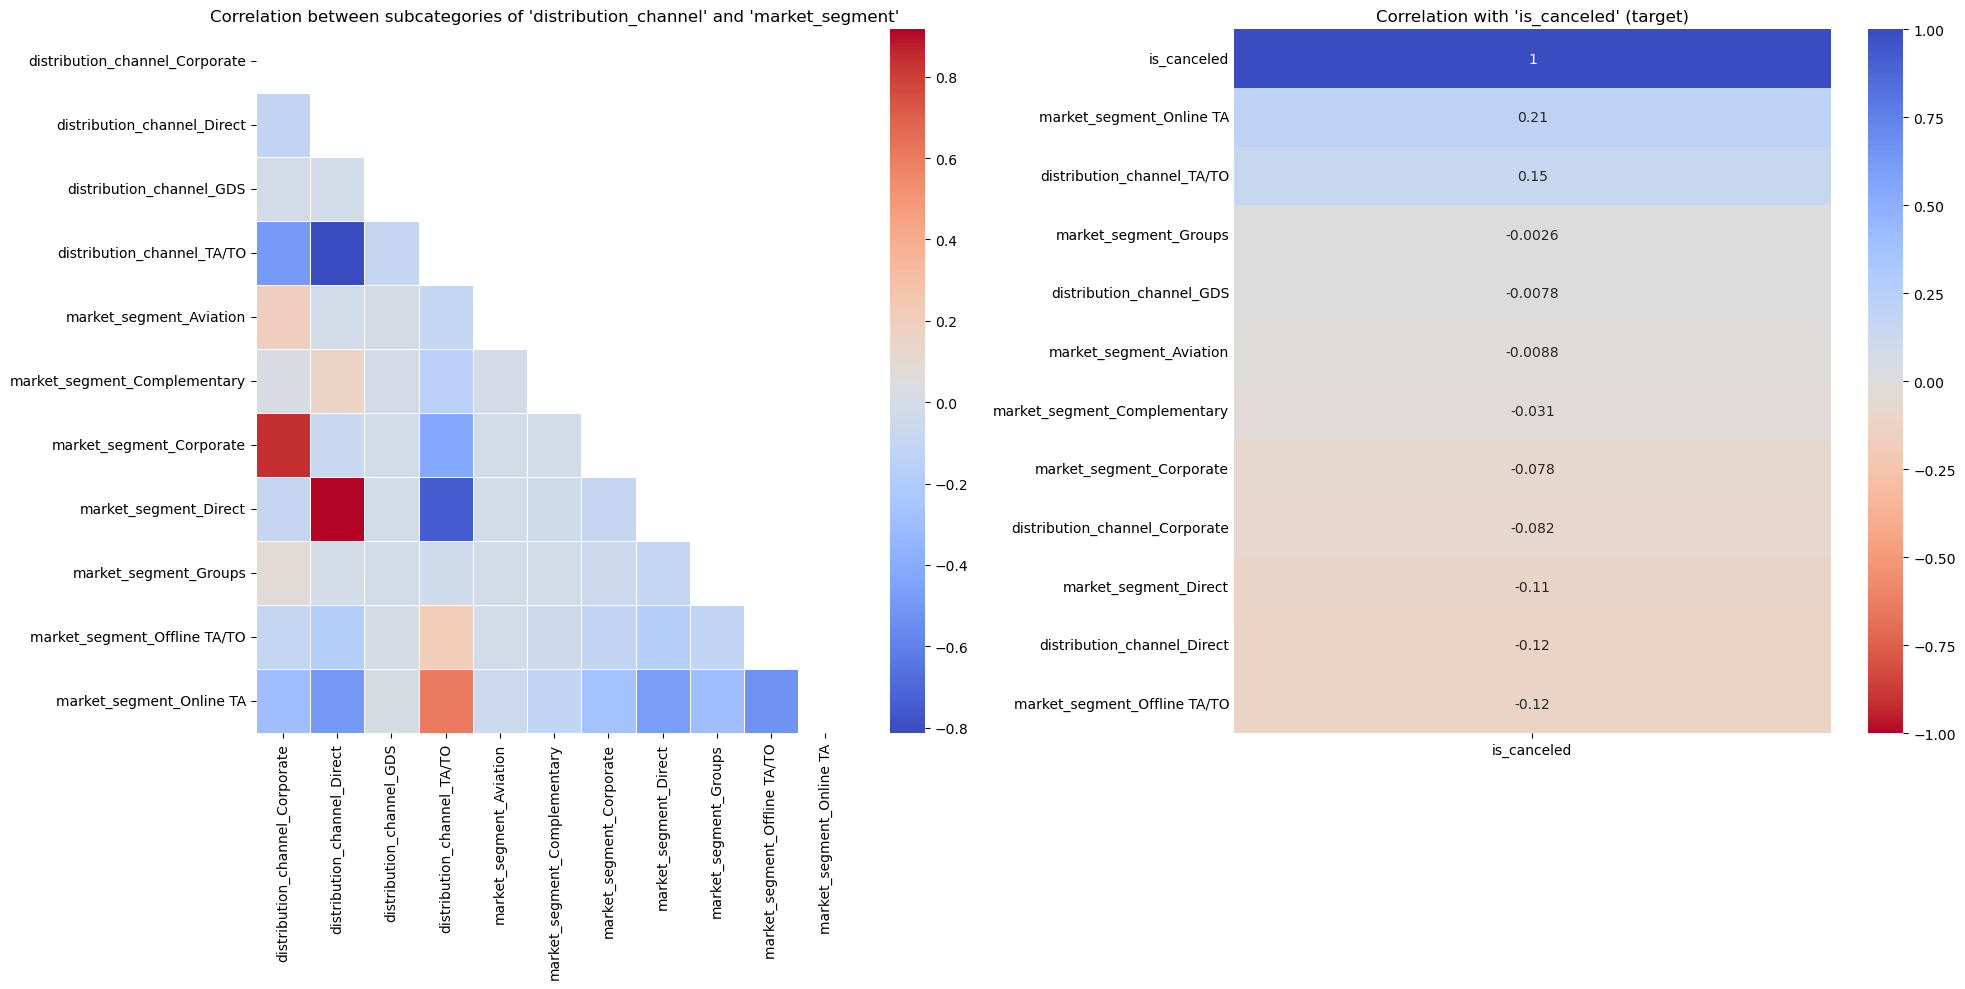

In [15]:
%matplotlib inline

# Encode categorical variables for 'distribution_channel' and 'market_segment'
encoded_df = pd.get_dummies(df[['distribution_channel', 'market_segment']])

# Compute correlation matrix for the encoded features
corr_matrix = encoded_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Initialize the matplotlib figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Correlation between subcategories of 'distribution_channel' and 'market_segment'
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, ax=ax[0])
ax[0].set_title("Correlation between subcategories of 'distribution_channel' and 'market_segment'")

# Encode categorical variables again for correlation with target
# This step seems repetitive from the description, so ensure your DataFrame 'encoded_df' is ready before this step
encoded_df['is_canceled'] = df['is_canceled']

# Correlation Heatmap with target for the second plot
corr_with_target = encoded_df.corr()["is_canceled"].sort_values(ascending=False).to_frame()

# Plot 2: Correlation with is_canceled (target)
sns.heatmap(corr_with_target, annot=True, cmap="coolwarm_r", cbar=True, vmin=-1, vmax=1, center=0, ax=ax[1])
ax[1].set_title("Correlation with 'is_canceled' (target)")
ax[1].tick_params(axis='y', length=0)  # Remove ticks from y-axis

plt.tight_layout()
plt.show()


### Strategic Feature Reduction for Predictive Accuracy

During the data analysis, we have decided to drop the following columns for the reasons specified:

- `reservation_status`: This column can cause data leakage for our target variable `is_canceled`. The status `Check-Out` implies that the customer did not cancel, which directly reveals the target.

- `reservation_status_date`: Similarly to `reservation_status`, this column could cause data leakage since the date of status might imply cancellation or not.

- `arrival_date_year`: The year of arrival would indicate that the booking was not canceled if they have arrived, leading to potential data leakage.

- `arrival_date_week_number`: This is being dropped for the same reason as `arrival_date_year`; its presence might reveal whether a booking was canceled.

- `assigned_room_type`: The type of room assigned can hint at whether the customer arrived; thus, it may not be canceled. Since `reserved_room_type` is retained, it captures the necessary room type information without potential data leakage.

- `distribution_channel`: This feature is highly correlated with `market_segment`. To reduce multicollinearity and to keep the dataset more concise, we are retaining the feature that has more distinctive categories and a higher correlation with the target variable.

- `arrival_date_day_of_month`: The day of the month is less informative compared to the week number for patterns such as holidays, which may have a more pronounced effect and do not typically span over a month. Since the `arrival_date_week_number` is more granular and informative for such patterns, we retain it and drop the day of the month.

These decisions are aimed at creating a more robust dataset for predictive modeling, ensuring that our features are informative without causing data leakage and reducing multicollinearity where possible.


In [16]:
# Drop specified columns
df = df.drop([
              'reservation_status',        # Would cause data leakage for our target variable 'is_canceled', if they did "Check-Out", they didn't cancel
              'reservation_status_date',   # Dito
              'arrival_date_year',         # Dito, if they arrived; they didn't cancel 
              'arrival_date_week_number',  # Dito, if they arrived; they didn't cancel 
              'assigned_room_type',        # Dito, if they were assigned a room, they may have arrived and hence not canceled ('reserved_room_type' is kept)
              'distribution_channel',      # Highly correlated with 'market_segment', we keep the one with more interesting categories and higher corr with target
              'arrival_date_day_of_month', # Already captured in 'arrival_date_week_number' which is more interesting given its higher granualirty for things like holidays, which doesn't span over months
], axis=1)

## Predictive Modelling: Logistic Regression

In [17]:
import pandas as pd
import warnings
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer

# Suppress warnings about unknown categories
#warnings.filterwarnings(action='ignore', message='Found unknown categories')

# Define features and target variable
X = df.drop(columns=['is_canceled'])  # Exclude target variable
y = df['is_canceled']

# Split the data into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)

# Initialize and fit the TargetEncoder on training data
target_encoder = TargetEncoder()
X_train['country'] = target_encoder.fit_transform(X_train['country'], y_train)
X_val['country'] = target_encoder.transform(X_val['country'])
X_test['country'] = target_encoder.transform(X_test['country'])

# Define transformers for numerical, 'agent', and categorical features
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='error', drop='first'))

# Define column selectors for numerical and categorical features
num_features = make_column_selector(dtype_include='number')
cat_features = make_column_selector(dtype_include=object)

# Make the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    verbose_feature_names_out=False  # This ensures the original feature names are maintained
)

# Instantiate the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Create the pipeline
pipe = make_pipeline(preprocessor, log_reg_model)

# Define hyperparameter grid
param_grid = {
    'logisticregression__C': [0.5, 1, 2],     # Inverse of regularization strength; smaller values specify stronger regularization.
    'logisticregression__penalty': ['l2'],    # 'lbfgs' supports only 'l2', 'saga' supports both 'l1' and 'l2'
    'logisticregression__solver': ['lbfgs'],  # Solver
    'logisticregression__tol': [0.0001],      # Stopping criteria precision. Default: 0.0001.
}

# Perform CV hyperparameter search
grid_logreg = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

# Fit best estimator on training data
grid_logreg.fit(X_train, y_train)

# Print best accuracy score and corresponding parameters
print(f"Best score (Accuracy): {grid_logreg.best_score_}\n")
print("Best params:")
for key, value in grid_logreg.best_params_.items():
    print(f"{key}: {value}")

# Evaluate the model on train and validation data
y_pred = grid_logreg.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print(f"\nAccuracy on train data: {grid_logreg.score(X_train, y_train)}")
print(f"Accuracy on test data: {accuracy}")
print(f"\nClassification Report on validation data: \n{class_report}")

Best score (Accuracy): 0.7923642903858731

Best params:
logisticregression__C: 2
logisticregression__penalty: l2
logisticregression__solver: lbfgs
logisticregression__tol: 0.0001

Accuracy on train data: 0.7925931981687377
Accuracy on test data: 0.7855943842514879

Classification Report on validation data: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      9504
           1       0.67      0.44      0.53      3602

    accuracy                           0.79     13106
   macro avg       0.74      0.68      0.69     13106
weighted avg       0.77      0.79      0.77     13106



### Metrics and Initial Evaluation Summary
In our quest to develop the most profitable model, our focus hinges on optimizing for True Positives (TP) and minimizing False Positives (FP). Each TP, where we accurately predict a customer will cancel their booking, results in a gain of 1000 SEK due to the effectiveness of sending a special deal to retain the customer. Conversely, each FP, where we incorrectly predict a cancellation and unnecessarily send a special deal, incurs a loss of 500 SEK.

Our chosen metric for maximizing profit is "precision," which currently stands at 0.67 according to the classification report. Analyzing the confusion matrix on our validation data reveals 782 bookings misclassified as cancellations (FP), representing a potential loss of 391,000 SEK (782 bookings * 500 SEK). On the other hand, we correctly identified 1574 bookings as potential cancellations (TP), implying a theoretical gain of 1,574,000 SEK (1574 bookings * 1000 SEK) if all retained customers through the special deal contribute to this profit.

This preliminary evaluation suggests a profitable scenario, yet emphasizes the need to enhance our model’s precision to further increase profitability by reducing the incidence of FPs and bolstering TPs.

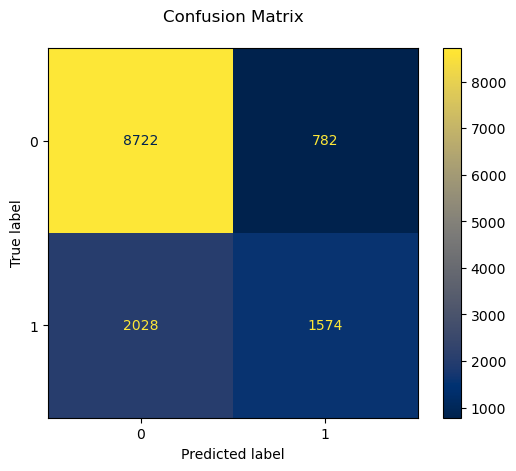

In [32]:
# Confusion Matrix from estimator
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_logreg, X_val, y_val, cmap='cividis')
plt.title('Confusion Matrix', y=1.05)
plt.show()

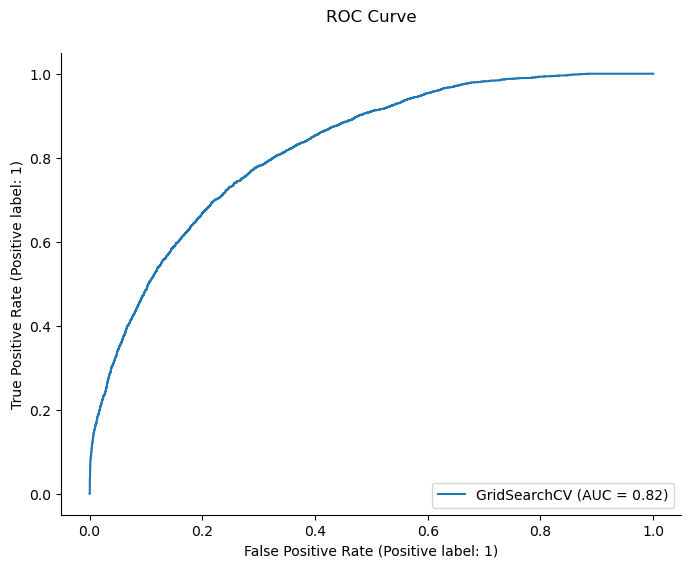

In [33]:
# Generate and plot ROC curve
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(grid_logreg, X_val, y_val, ax=ax)
plt.title('ROC Curve', y=1.05)
sns.despine()

### Variance Inflation Factor (VIF) and Next Steps
Through our prior meticulous data cleaning and analysis efforts, we have identified and addressed features that could be problematic due to multicollinearity, data leakage, etc. As a result, the VIF score has been reduced to an acceptable level. Further pruning of features without any underlying motivation or insight could lead to a loss of predictive power. Therefore, the next step in our modeling process will involve deploying inferential modeling and statistical analysis to enable more targeted feature selection. This approach is aimed at exploring the balance between performance and interpretability in our model.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Convert transformed features into DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()

# Sample a fraction of the data, e.g., 10%
sample_fraction = 0.1
X_train_transformed_df_sample = X_train_transformed_df.sample(frac=sample_fraction, random_state=42)

def calculate_vif(X):
    # Calculate VIF for each feature in a DataFrame
    return pd.DataFrame(
        {'feature': X.columns,
         'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })

# Call the function and sort the results
vif_data = calculate_vif(X_train_transformed_df_sample)  # X_train.drop(columns=['const']
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data[:5]

,feature,VIF
37,market_segment_Online TA,24.186627
48,customer_type_Transient,23.191854
36,market_segment_Offline TA/TO,7.333084
34,market_segment_Direct,6.691198
49,customer_type_Transient-Party,5.017951


## Inferential Modelling: Logistic Regression
To get a better understanding of which variables are instrumental for our model, as well as how logistic regression is performing overall, we perform inferential modeling using `statsmodel.api`. If interpretability over time is more important to the stakeholders than pure performance, a possible scenario would be to go with Logistic Regression over more performant models for deployment. Regardless of our model of choice, the insights that we can glean from the inferential modeling can still be valuable and give a better understanding of what affects whether a customer will cancel their booking or not.

### Evaluating Logistic Regression as a Predictive Model
We can from the result summary below discern that the overall model is significant, however, the $R^2$ of 0.2579, Log-Likelihood -26689 and LL-Null -35963 tells us the following.
- $R^2$ (0.2579): The explanatory power of the model is not optimal
- LL(model) vs LL(null): The log-likelihood of the fitted model is indeed better (lower) than guess work i.e the null model. However, it's not all too impressive.

The logistic regression may not be capturing complex patterns in the data, indicating a gap in its explanatory power that other models could potentially fill. Nevertheless, with a precision of 0.69, the model shows usefulness. Therefore, we will continue to scrutinize and examine the model in the subsequent sections.

In [20]:
import statsmodels.api as sm

# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training and testing data
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())    # .toarray()

# Add a constant term for the intercept for statsmodels
X_train_sm = sm.add_constant(X_train_transformed_df).reset_index(drop=True)
X_val_sm = sm.add_constant(X_test_transformed_df).reset_index(drop=True)
X_test_sm = sm.add_constant(X_test_transformed_df).reset_index(drop=True)

# Reset index for y_train
y_train = y_train.reset_index(drop=True)

# Create a Logit model
logit_model = sm.Logit(y_train, X_train_sm)

# Fit model without regularization
# result = sm.Logit(y_train, X_train_sm).fit(method='lbfgs')

result = logit_model.fit_regularized(method='l1', 
                                     alpha=2.2,
                                     maxiter=10000, 
                                     solver='lbfgs',
                                     #trim_mode='size',    # Enable manual trimming
                                     #size_trim_tol=0.01,  # Coefficients with an absolute value less than 0.01 will be set to zero
                                     tol=1e-5              # Decrease tolerance to increase solver accuracy
                                    )

# Print the summary of the model
print(result.summary())

# Calculate and print AIC and BIC
aic_no_z = result.aic  # Akaike Information Criterion
bic_no_z = result.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic_no_z}")
print(f"BIC: {bic_no_z}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4371253238299202
            Iterations: 604
            Function evaluations: 604
            Gradient evaluations: 604
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                61160
Model:                          Logit   Df Residuals:                    61114
Method:                           MLE   Df Model:                           45
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.2579
Time:                        13:01:33   Log-Likelihood:                -26689.
converged:                       True   LL-Null:                       -35963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

### Coefficients and P-values
After some hyperparameter tuning to eliminate convergence warnings, we are now poised to analyze the coefficients and p-values. Our diligent preprocessing has ensured that no variables are completely insignificant, although some subcategories in the encoding remain so, which is to be expected.

A few variables—specifically, certain subcategories—do not significantly predict cancellations, as indicated by a zero coefficient from the regularization:
- reserved_room_type_H
- reserved_room_type_C
- meal_SC
- meal_FB
- arrival_date_month_February

This provides intriguing insights from an interpretability standpoint: these factors do not enhance the model's performance. For instance, a booking made in February does not help predict cancellations compared to bookings made in July, August, or September. Further investigation is required to fully understand why these do not furnish the model with valuable information. However, this allows us to hypothesize that the summer months—peak vacation time—might prompt more second-guessing of vacation plans, leading to cancellations.

In [40]:
# Extract the summary as a dataframe
summary_df = pd.DataFrame(result.summary().tables[1].data)

# Assign the first row as the header
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df.drop(0)

# Convert the 'coef' and 'P>|z|' columns to numeric, setting errors to 'coerce' which converts invalid parsing to NaN
summary_df['coef'] = pd.to_numeric(summary_df['coef'], errors='coerce')
summary_df['P>|z|'] = pd.to_numeric(summary_df['P>|z|'], errors='coerce')

# Replace NaN values with 0 in these columns
summary_df['coef'] = summary_df['coef'].fillna(0)
summary_df['P>|z|'] = summary_df['P>|z|'].fillna(0)

# Filter the dataframe for significant coefficients (p < 0.05)
significant_coefs_df = summary_df[summary_df['P>|z|'] < 0.05]

# Drop unnecessary columns
significant_coefs_df = significant_coefs_df[['', 'coef', 'P>|z|']].rename(columns={'': 'feature'})

significant_coefs_df.reset_index(drop=True, inplace=True)
significant_coefs_df = significant_coefs_df.sort_values(by="coef", ascending=False)

print('Variables with the strongest coefficients ')

# Display the most significant coefficients
pd.concat([significant_coefs_df.head(3), significant_coefs_df.tail(4)])


Variables with the strongest coefficients 


,feature,coef,P>|z|
39,deposit_type_Non Refund,3.1550,0.000
33,market_segment_Online TA,0.7735,0.000
40,deposit_type_Refundable,0.6978,0.027
16,total_of_special_requests,-0.5729,0.000
32,market_segment_Offline TA/TO,-0.7636,0.000
0,const,-2.7521,0.000
15,required_car_parking_spaces,-3.5046,0.000


#### Analyzing Features with Higher Magnitude Coefficients: Part 1
Below is a plot examining variables of particular interest to the model that exhibited stronger coefficients. Although these plots do not directly analyze the coefficients, they provide insights into the distribution of the target variable across the predictors, offering valuable perspectives for stakeholders:

- Bookings with non-refundable deposits are more likely to be canceled. This could be seen as positive for the business, but what does it imply for customer satisfaction?

- Bookings made through online travel agencies show a higher cancellation rate compared to others. Does this channel yield profit, or should we focus on other, more lucrative channels?

- A greater number of special requests and required car parking spaces indicate firmer bookings; they are less prone to cancellation.

Four coefficients with the most significant impact:
- deposit_type_Non Refund and deposit_type_Refundable
- market_segment_Online TA
- required_car_parking_spaces
- total_of_special_requests

As depicted by the normalized data, with classes shown as percentages, the strength of the coefficients aligns with the analysis of the target's proportion within the classes. Note that the bars are annotated with the total count to provide a scale of magnitude.

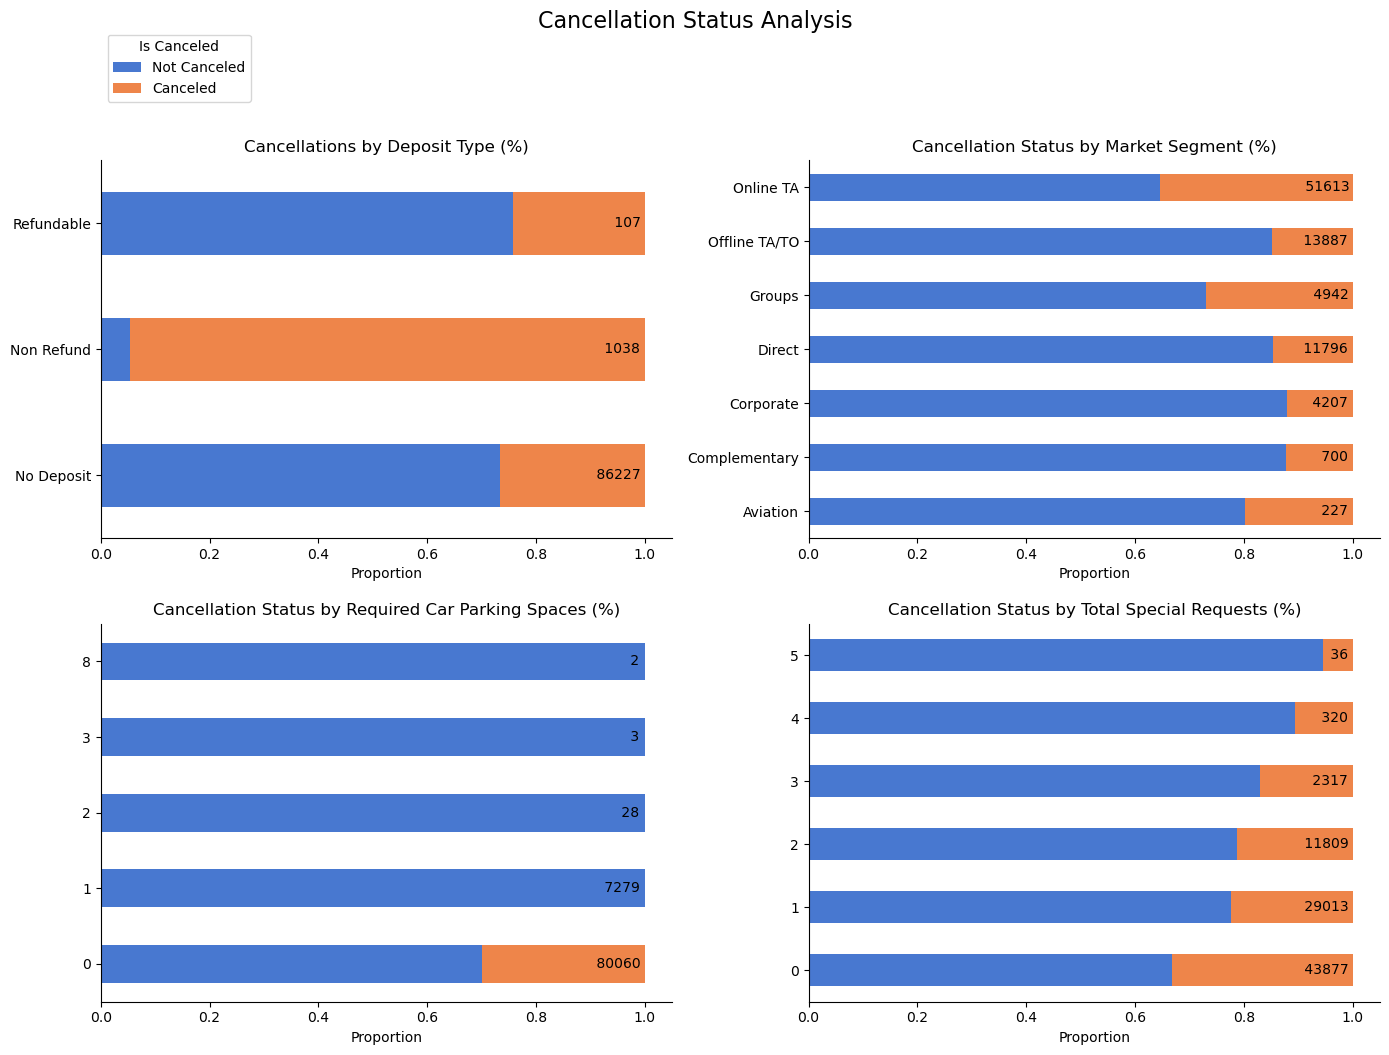

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample DataFrame
# df = pd.read_csv('your_dataset.csv')  # Assuming df is your DataFrame

# Define the palettes
palettes = ["muted", "muted", "muted", "muted"]

# Define the plot titles
plot_titles = [
    'Cancellations by Deposit Type (%)',
    'Cancellation Status by Market Segment (%)',
    'Cancellation Status by Required Car Parking Spaces (%)',
    'Cancellation Status by Total Special Requests (%)'
]

# Define the columns for each plot
columns = [
    ['deposit_type', 'is_canceled'],
    ['market_segment', 'is_canceled'],
    ['required_car_parking_spaces', 'is_canceled'],
    ['total_of_special_requests', 'is_canceled']
]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cancellation Status Analysis', fontsize=16, y=1.05)  # Add a big title

for ax, palette, title, column in zip(axes.flatten(), palettes, plot_titles, columns):
    # Group the data and calculate proportions
    grouped_data = df.groupby(column).size().unstack(fill_value=0)
    totals = grouped_data.sum(axis=1)  # Total counts for each group
    proportions = grouped_data.div(totals, axis=0)  # Normalize to proportions
    
    # Plotting with normalized data
    sns.set_palette(palette)
    bars = proportions.plot(kind='barh', stacked=True, ax=ax)  # Use proportions for plotting
    
    # Annotation for total counts
    for i, (index, row) in enumerate(proportions.iterrows()):
        total = totals.loc[index]  # Get total count for the current group
        # Adjust x position by subtracting a small value to move text slightly to the left
        x_position = row.cumsum().values[-1] - (row.max() * 0.01)  # Adjust here as needed
        ax.text(x_position, i, f' {total}', va='center', ha='right')

    # Adjust plot aesthetics
    ax.set_title(title)
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    
    # Add legend only to the first subplot
    if ax == axes.flatten()[0]:
        ax.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'], loc='upper left', bbox_to_anchor=(0, 1.35))
    else:
        # Remove legend from other subplots
        ax.get_legend().remove()
    
    sns.despine(ax=ax)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top margin to make room for the big title
plt.show()

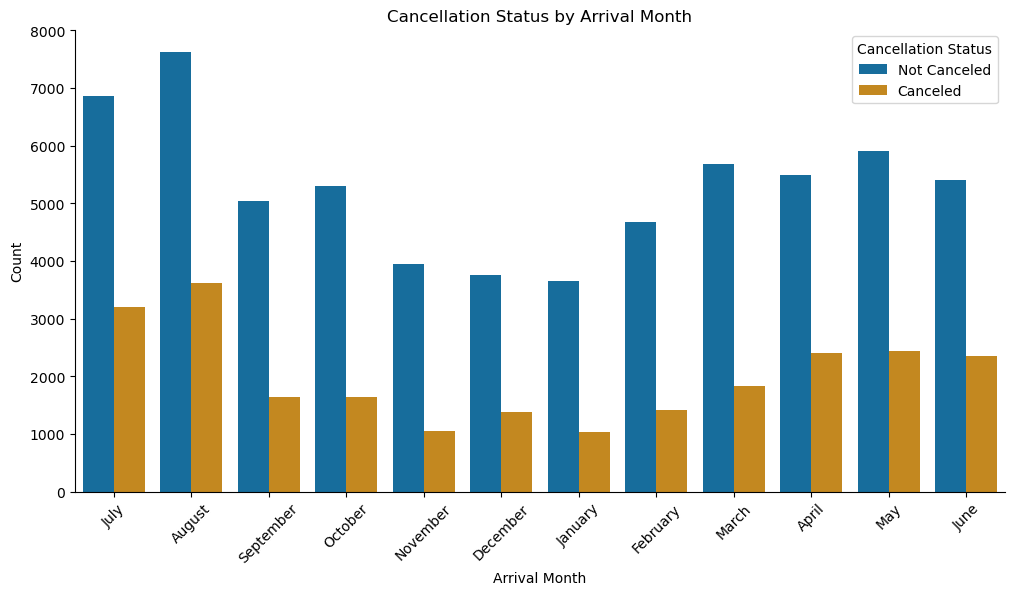

In [ ]:
# Plotting
sns.set_palette('colorblind')
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='arrival_date_month', hue='is_canceled', order=df['arrival_date_month'].unique())
plt.title('Cancellation Status by Arrival Month')
plt.xlabel('Arrival Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
sns.despine()

In [22]:
# Create a contingency table and calculate percentages
contingency_table = pd.crosstab(df['market_segment'], df['is_canceled'], normalize='index') * 100

# Sort by the highest percentage of is_canceled being 1
contingency_table_sorted = contingency_table.sort_values(by=1, ascending=False)

# Apply background gradient only for is_canceled being 1
(contingency_table_sorted
 .style
 .background_gradient(cmap='RdBu_r', subset=[1])
)


is_canceled,0,1
market_segment,,
Online TA,64.654254,35.345746
Groups,72.986645,27.013355
Aviation,80.176211,19.823789
Offline TA/TO,85.158782,14.841218
Direct,85.300102,14.699898
Complementary,87.714286,12.285714
Corporate,87.901117,12.098883


In [23]:
# Top N countries with the highest frequency of bookings
top_countries = df['country'].value_counts().nlargest(10).index.tolist()

# Filter the DataFrame to include only the top N countries
df_filtered = df[df['country'].isin(top_countries)]

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['country'], df_filtered['is_canceled'], normalize='index') * 100

# Find the maximum percentage of is_canceled being 1
max_percent_canceled = contingency_table[1].max()

(contingency_table
 .sort_values(by=1, ascending=False)
 .style
 .background_gradient(cmap='RdBu_r', subset=[1], vmax=max_percent_canceled)
)


is_canceled,0,1
country,,
BRA,63.558897,36.441103
PRT,64.340125,35.659875
ITA,64.938030,35.061970
ESP,74.324324,25.675676
IRL,77.851459,22.148541
BEL,80.249880,19.750120
FRA,80.389272,19.610728
DEU,80.452942,19.547058
GBR,80.972009,19.027991


In [24]:
import geopandas as gpd

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the contingency table to include cancellation percentages
world = world.merge(contingency_table, how='left', left_on='name', right_index=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column=1, cmap='RdBu_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Percentage of Cancellations by Country')
plt.show()


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
from sklearn.feature_selection import RFECV
import pandas as pd

# Assuming preprocessor is defined elsewhere and includes all preprocessing steps

# Instantiate the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Assuming X_train, y_train, X_test, y_test are already defined

# Apply preprocessing pipeline to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert preprocessed data back to DataFrame to keep column names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessor.get_feature_names_out())
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())

# Use RFECV for feature selection with logistic regression as the estimator
selector = RFECV(estimator=log_reg_model, step=1, cv=5, scoring='accuracy')
selector = selector.fit(X_train_preprocessed_df, y_train)

# Mask to filter selected features
mask = selector.support_

# Get the selected features from the mask
selected_features = X_train_preprocessed_df.columns[mask]

# Create DataFrames with selected features only
X_train_selected_df = X_train_preprocessed_df[selected_features]
X_test_selected_df = X_test_preprocessed_df[selected_features]

# Fit the logistic regression model on the selected features
log_reg_model.fit(X_train_selected_df, y_train)

# Predict and evaluate
y_pred = log_reg_model.predict(X_test_selected_df)
accuracy = accuracy_score(y_test, y_pred)
#class_report = classification_report(y_test, y_pred)

print(f"Selected Features: {selected_features.tolist()}")

ValueError: Shape of passed values is (95121, 1), indices imply (95121, 991)

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
selector.support_

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
# Get list of tuples with ranking and feature names
ranked_features = sorted(zip(selector.ranking_, selected_features))

# print("Feature ranking:")
# for rank, name in ranked_features:
#     print(f"Rank {rank}: {name}")

print("\nTop 5 features:")
for rank, name in ranked_features[:5]:
    print(f"Rank {rank}: {name}")

print("\nSelected features (Rank 1):")
for selected, name in zip(selector.support_, selected_features):
    if selected:
        print(name)


Top 5 features:
Rank 1: pipeline-1__adr
Rank 1: pipeline-1__adults
Rank 1: pipeline-1__arrival_date_year
Rank 1: pipeline-1__booking_changes
Rank 1: pipeline-1__children

Selected features (Rank 1):
pipeline-1__lead_time
pipeline-1__arrival_date_year
pipeline-1__stays_in_week_nights
pipeline-1__adults
pipeline-1__children
pipeline-1__country
pipeline-1__previous_cancellations
pipeline-1__previous_bookings_not_canceled
pipeline-1__booking_changes
pipeline-1__adr
pipeline-1__required_car_parking_spaces
pipeline-2__agent
pipeline-3__hotel_Resort Hotel
pipeline-3__arrival_date_month_August
pipeline-3__arrival_date_month_December
pipeline-3__arrival_date_month_January
pipeline-3__arrival_date_month_July
pipeline-3__arrival_date_month_June
pipeline-3__arrival_date_month_May
pipeline-3__arrival_date_month_November
pipeline-3__arrival_date_month_October
pipeline-3__arrival_date_month_September
pipeline-3__meal_FB
pipeline-3__meal_HB
pipeline-3__meal_SC
pipeline-3__meal_Undefined
pipeline-3__m

In [ ]:
selector.ranking_

array([1, 1, 6, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 7,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [ ]:
# Removed for low p-values
'arrival_date_day_of_month', 'babies'


In [ ]:
Accuracy on test data: 0.8858188241231391

Classification Report on test data: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     14948
           1       0.88      0.80      0.84      8830

    accuracy                           0.89     23778
   macro avg       0.89      0.87      0.87     23778
weighted avg       0.89      0.89      0.88     23778

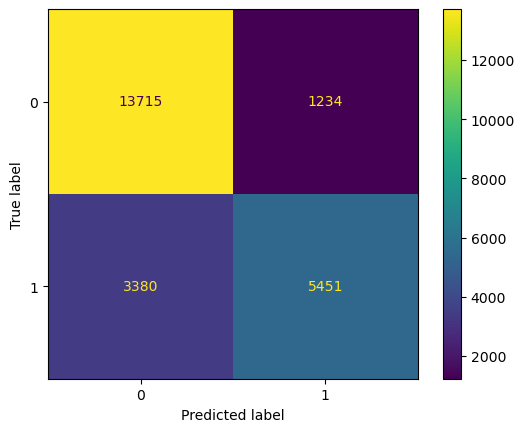

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(grid_logreg, X_test, y_test)
plt.show()


In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Suppress warnings about unknown categories
warnings.filterwarnings(action='ignore', message='Found unknown categories')

# Load dataset
df = pd.read_csv('hotel_bookings.csv')

# Drop specified columns
df = df.drop(['reservation_status', 'reservation_status_date'], axis=1)

# Define features and target variable
X = df.drop(columns=['is_canceled'])  # Exclude target variable
y = df['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define transformers for numerical and categorical features
num_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first'))

# Define column selectors for numerical and categorical features
num_features = make_column_selector(dtype_include='number')
cat_features = make_column_selector(dtype_include=object)

# Make the column transformer
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
)

# Instantiate the random forest classifier model
rf_model = RandomForestClassifier()

# Create the pipeline
pipe = make_pipeline(preprocessor, rf_model)

# Fit the model
pipe.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy on train data: {pipe.score(X_train, y_train)}")
print(f"Accuracy on test data: {accuracy}")
print(f"\nClassification Report on test data: \n{class_report}")


Accuracy on train data: 0.9963355389898652
Accuracy on test data: 0.8939190887008962

Classification Report on test data: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     15033
           1       0.89      0.81      0.85      8845

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



In [ ]:
pd.options.display.max_columns = 100
X_train_sm

,const,pipeline-1__lead_time,pipeline-1__arrival_date_year,pipeline-1__arrival_date_week_number,pipeline-1__arrival_date_day_of_month,pipeline-1__stays_in_weekend_nights,pipeline-1__stays_in_week_nights,pipeline-1__adults,pipeline-1__children,pipeline-1__babies,pipeline-1__is_repeated_guest,pipeline-1__previous_cancellations,pipeline-1__previous_bookings_not_canceled,pipeline-1__booking_changes,pipeline-1__days_in_waiting_list,pipeline-1__adr,pipeline-1__required_car_parking_spaces,pipeline-1__total_of_special_requests,pipeline-2__agent,pipeline-3__hotel_City Hotel,pipeline-3__hotel_Resort Hotel,pipeline-3__arrival_date_month_April,pipeline-3__arrival_date_month_August,pipeline-3__arrival_date_month_December,pipeline-3__arrival_date_month_February,pipeline-3__arrival_date_month_January,pipeline-3__arrival_date_month_July,pipeline-3__arrival_date_month_June,pipeline-3__arrival_date_month_March,pipeline-3__arrival_date_month_May,pipeline-3__arrival_date_month_November,pipeline-3__arrival_date_month_October,pipeline-3__arrival_date_month_September,pipeline-3__meal_BB,pipeline-3__meal_FB,pipeline-3__meal_HB,pipeline-3__meal_SC,pipeline-3__meal_Undefined,pipeline-3__country_ABW,pipeline-3__country_AGO,pipeline-3__country_AIA,pipeline-3__country_ALB,pipeline-3__country_AND,pipeline-3__country_ARE,pipeline-3__country_ARG,pipeline-3__country_ARM,pipeline-3__country_ASM,pipeline-3__country_ATA,pipeline-3__country_ATF,pipeline-3__country_AUS,...,pipeline-3__country_USA,pipeline-3__country_UZB,pipeline-3__country_VEN,pipeline-3__country_VGB,pipeline-3__country_VNM,pipeline-3__country_ZAF,pipeline-3__country_ZMB,pipeline-3__country_ZWE,pipeline-3__market_segment_Aviation,pipeline-3__market_segment_Complementary,pipeline-3__market_segment_Corporate,pipeline-3__market_segment_Direct,pipeline-3__market_segment_Groups,pipeline-3__market_segment_Offline TA/TO,pipeline-3__market_segment_Online TA,pipeline-3__market_segment_Undefined,pipeline-3__distribution_channel_Corporate,pipeline-3__distribution_channel_Direct,pipeline-3__distribution_channel_GDS,pipeline-3__distribution_channel_TA/TO,pipeline-3__distribution_channel_Undefined,pipeline-3__reserved_room_type_A,pipeline-3__reserved_room_type_B,pipeline-3__reserved_room_type_C,pipeline-3__reserved_room_type_D,pipeline-3__reserved_room_type_E,pipeline-3__reserved_room_type_F,pipeline-3__reserved_room_type_G,pipeline-3__reserved_room_type_H,pipeline-3__reserved_room_type_L,pipeline-3__reserved_room_type_P,pipeline-3__assigned_room_type_A,pipeline-3__assigned_room_type_B,pipeline-3__assigned_room_type_C,pipeline-3__assigned_room_type_D,pipeline-3__assigned_room_type_E,pipeline-3__assigned_room_type_F,pipeline-3__assigned_room_type_G,pipeline-3__assigned_room_type_H,pipeline-3__assigned_room_type_I,pipeline-3__assigned_room_type_K,pipeline-3__assigned_room_type_L,pipeline-3__assigned_room_type_P,pipeline-3__deposit_type_No Deposit,pipeline-3__deposit_type_Non Refund,pipeline-3__deposit_type_Refundable,pipeline-3__customer_type_Contract,pipeline-3__customer_type_Group,pipeline-3__customer_type_Transient,pipeline-3__customer_type_Transient-Party
0,1.0,-0.784882,1.193298,-1.552382,-1.000803,-0.928908,-0.261137,-1.464604,-0.259968,-0.078866,-0.180512,-0.104002,-0.091345,-0.335916,-0.132847,-0.074093,-0.253754,-0.720366,1.123813,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,-0.897168,-0.221372,-1.185007,-0.773337,-0.928908,0.262232,0.246367,-0.259968,-0.078866,-0.180512,-0.104002,-0.091345,-0.335916,-0.132847,-0.034887,-0.253754,-0.720366,-0.699508,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('hotel_bookings.csv')

# Add a constant column for the intercept
df['intercept'] = 1

# Proceed with your preprocessing steps, excluding the target variable and columns to be dropped
df = df.drop(['company', 'reservation_status', 'reservation_status_date'], axis=1)

# Define features and target variable
X = df.drop(columns=['is_canceled'])  # Exclude target variable
y = df['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training and testing data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# # Convert the transformed features into DataFrames
# X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
# X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())

X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns=preprocessor.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed.toarray(), columns=preprocessor.get_feature_names_out())


# # Add a constant term for the intercept for statsmodels
X_train_sm = sm.add_constant(X_train_transformed_df)
X_test_sm = sm.add_constant(X_test_transformed_df)

# BONUS CHALLENGE 1!

- Try out building your own scoring function that you pass to the scoring parameter in the GridSearchCV object!

*Check out scikit-learns `make_scorer()` method*

# BONUS CHALLENGE 2!

- Instead of a LogReg model, use a RandomForestClassifier model!

Which model had the best performance? Was there a big difference?
